In [20]:
import pickle as pk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
from itertools import groupby

from sys import path
path.append('..')
from clearsky.main import IterativeClearSky

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Thoughts so far

I think certainly the frequency and wavelet transformed data gets clustered better than the raw or delta data, and that aggolomerative clustering is so far the best. However, it seems to me like the wavelets for some reason aren't having a high enough resolution of the time domain. As in, they aren't doing a good job of capturing the high frequency stuff in short windows, and it seems like it may be because the wavelets themselves are too long? Or I'm totally wrong about it.

Either way, I'm honestly thinking some hand made features might be able to perform even better, at least at separating overcast and clear days, and possibly even days that transition between the two states.

The features I'm thinking of would basically be stuff like:
1. The first order difference
2. The number of times the signal has decreased by more than some threshold
3. The number of times the signal has increased by more than some threshold
4. The variance of the signal in the past `n` samples
5. Duplicates of 2 and 3, but limited to tracking only in the past `n` samples

Basically, I'm guessing that these sorts of features might be better able to capture the rainy vs. clear behavior, and also at a very fine resolution, potentially.

## Loading Data 

In [2]:
# Run the script to get the data if it hasn't already been pickled
# To change what data you get, go into the script and change the START_DATE
# and END_DATE values near the top of the script
# exec(open('./tutorial_data_setup.py').read())

# If the script has already been run, data is saved locally, so load it
full_data = pk.load( open( "data/tutorial_data_no_leap.pkl", "rb" ) )

# Get just the columns that are solar generation
data = full_data['gen'][['solar_home1', 'solar_home2', 'solar_home3', 'solar_home4']][:-1]

In [8]:
# Define some constants
N = 96 # number of intervals in a day
num_homes = 4
num_days = int(len(data)/N)

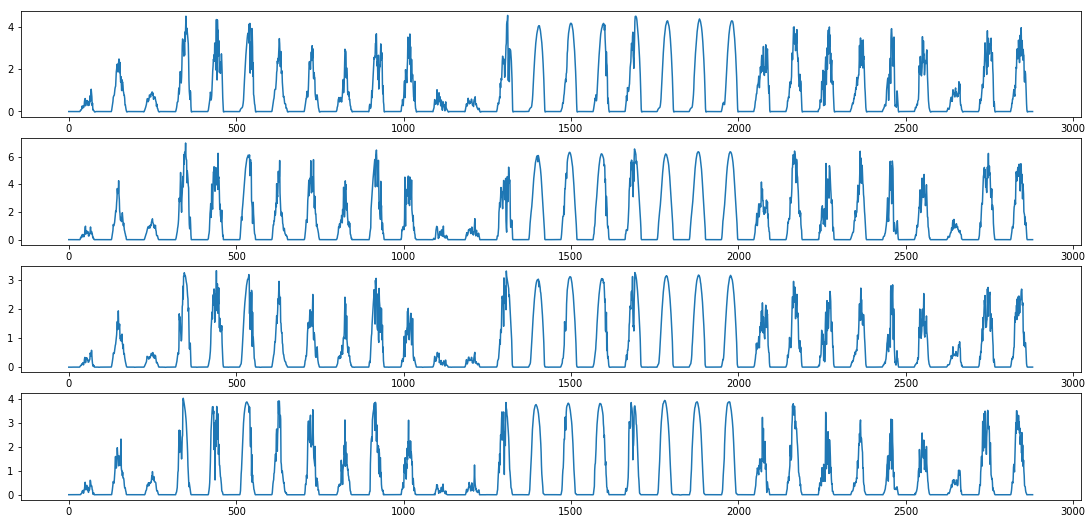

In [10]:
# Take a look at some of the data
plt.figure(figsize=(19,9))
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.plot(data['solar_home' + str(i)].values[:30*N])

plt.show();

# Fitting Clearsky Model

Todo: try changing the $k$ argument in IterativeClearSky

In [11]:
# Now, fit the clearsky model to each site, then subtract that from the baseline, and put them all in one matrix

ics_vec = [] # vector of ICS objects
delta_data = np.zeros((N, num_days*num_homes)) # the data with the clearsky subtracted out
raw_data = np.zeros_like(delta_data) # data matrix of original data, for reference

# For each site:
for i in range(num_homes):
    site_str = 'solar_home' + str(i+1)
    site_data = data[site_str].values
    
    # Split the data for the site up into daily intervals along columns
    site_mat = np.reshape(site_data, (N, num_days), 'F')
    
    # Add to the raw_data matrix
    raw_data[:, i*num_days:(i+1)*num_days] = site_mat

    # Get the clearsky model for that site
    ics = IterativeClearSky(site_mat, k=4)
    ics.minimize_objective(verbose=False)
    ics_vec.append(ics)
    
    # Get what the clearsky model prediction is
    csky_mat = (ics.L_cs.value @ ics.R_cs.value)
    
    # Subtract the clearsky model from the actual data
    delt_mat = site_mat - csky_mat
    
    # Add the delt_data to the matrix to keep track of all delt_data
    delta_data[:, i*num_days:(i+1)*num_days] = delt_mat
    
    print('Iter complete')

Iter complete
Iter complete
Iter complete
Iter complete


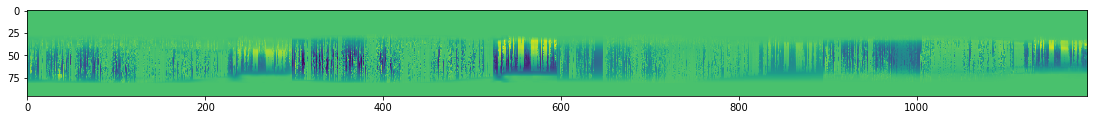

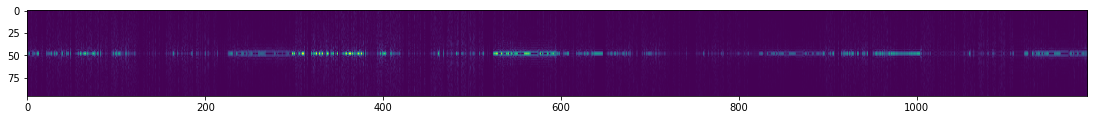

In [440]:
plt.figure(figsize=(19,10))
plt.imshow(delta_data)
plt.show()

freq_data = np.fft.fftshift(np.fft.fft(delta_data, axis=0), axes=0)
plt.figure(figsize=(19,10))
plt.imshow(np.abs(freq_data))
plt.show()

Now, we have three data matrices: `raw_data`, `delta_data` and `freq_data`. All are of shape (`N`, `num_homes * num_days`), where `N` is the number of intervals in a day (so 96). That is, each column is a data point of one day's solar generation at one of the sites. 

`raw_data` matrix contains the original generation data. <br>
`delta_mat` contains the original data that then had the ClearSky forecast subtracted out of it. <br>
`freq_data` is such that each column is the FFT of each column of `delta_data`.

# Wavelet Feature Extraction

We're going to now extract features from the data using wavelet transform, and then try the clustering again. Basing work off of [this blog post](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/).

I would like to try two different types of wavelets: one that looks like a clear day, and one that looks like the overcast day, and see if using these different archetypes will help separate the days or not. However, I don't really see much significant difference between different wavelets. Just seems like definitely don't use ones that are so long that the signal is only filtered to level 2 or 3.

In [397]:
# Helper functions for counting number of consecutive values in calculate_diff_features
def len_iter(items):
    return sum(1 for _ in items)

def consecutive_vals(data, target_val):
    if data.__contains__(target_val):
        return max(len_iter(run) for val, run in groupby(data) if val==target_val)
    else:
        return 0

def calculate_diff_features(list_values):
    # Get the first order difference vector
    diff_vec = np.diff(np.array(list_values))
    
    # Count the number of positive differences and negative differences
    num_ups = np.count_nonzero(diff_vec > 0)
    num_downs = np.count_nonzero(diff_vec < 0)
    
    # Calculate the biggest single period increase and single period decrease
    if len(list_values) == 1:
        biggest_up = 0
        biggest_down = 0
    else:
        biggest_up = np.amax(diff_vec)
        biggest_down = np.amin(diff_vec)
    
    # TODO: Calculate the total variation
    
    # Count the longest instance of consecutive ups and downs
    binary_diffs = np.sign(diff_vec)
    longest_consec_ups = consecutive_vals(binary_diffs, 1)
    longest_consec_downs = consecutive_vals(binary_diffs, -1)
    
    
    # Consider the number of flips from down to up and up to down
    diff_switch_vec = np.diff(binary_diffs)
    up_downs = np.count_nonzero(diff_switch_vec == -2)
    down_ups = np.count_nonzero(diff_switch_vec == 2)

    return_list = [num_ups, num_downs, 
                   biggest_up, biggest_down,
                   longest_consec_ups, longest_consec_downs, 
                   up_downs, down_ups]
    
    return return_list
    

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [std, var, rms]
#     return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    num_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    num_mean_crossings = len(mean_crossing_indices)
    return [num_zero_crossings, num_mean_crossings]

def get_features(list_values):
    '''
    Input is a list, itself which is one of the elements which is returned by pywt.wavedec()
    So usage looks like:
    coeff_list = pywt.wavedec(signal, wavelet_name_str)
    features = get_features(coeff_list[0])   # <-- can be any index, not just 0'th index
    
    Features returned are:
    num_zeros_crossings, num_mean_crossings,
    5th percentile, 25th percentile, 75th percentile, 95th percentile, median, mean,
    std, var, rms
    
    so returned array is 11 long
    
    After adding the diff features, it's now 29 long
    '''
    list_values = np.array(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    diff_feats = calculate_diff_features(list_values)
    # Also get diff features for first half and second half, separately
    len_list_vals = len(list_values)
    first_half_diff_feats = calculate_diff_features(list_values[:int(len_list_vals/2)])
    second_half_diff_feats = calculate_diff_features(list_values[int(len_list_vals/2):])
    
    feat_list = (crossings, statistics, diff_feats, first_half_diff_feats, second_half_diff_feats)
    flatten = [[item for sublist in feat_list for item in sublist]]
    return np.array(flatten).squeeze()

In [384]:
def build_wavelet_feature_matrix(data, wavelet_name):
    '''
    Builds and returns a matrix of features extracted from wavelet transform
    Matrix will be (num_features, num_pts) where num_pts is the same as the number
    of columns in data. Data is assumed to be such that columns are the data points
    '''
    num_pts = data.shape[1]
    # This depends on the get_features function. If you change the number of features,
    # you need to change this number to match. That, or you could just not pre-allocate
    # the memory and append it instead, if the performance difference isn't too bad
    num_feats = 29

    test_coeffs = pywt.wavedec(data[:,0], wavelet_name)
    num_coeffs = len(test_coeffs)
    
    print('Max level wavelet reached: ', num_coeffs)

    # First, try taking features from the detail and not the LP part (opposite of what was shown
    # by the diagram in the lecture slides)
    feature_mat = np.zeros((num_coeffs*num_feats, num_pts))
    for i in range(num_pts):
        pt = data[:, i]
        coeff_list = pywt.wavedec(pt, wavelet_name)
        combined_feats = np.zeros(len(coeff_list)*num_feats)

#         plt.figure(figsize=(19,10))
#         plt.subplot(len(coeff_list)+1, 1, 1)
#         plt.plot(pt)
        
        for k, coeffs in enumerate(coeff_list):
            combined_feats[(k*num_feats):(k+1)*num_feats] = get_features(coeffs)
            
#             plt.subplot(len(coeff_list)+1, 1, k+2)
#             plt.plot(coeffs)
#         plt.show()

        feature_mat[:, i] = combined_feats
    
    return feature_mat

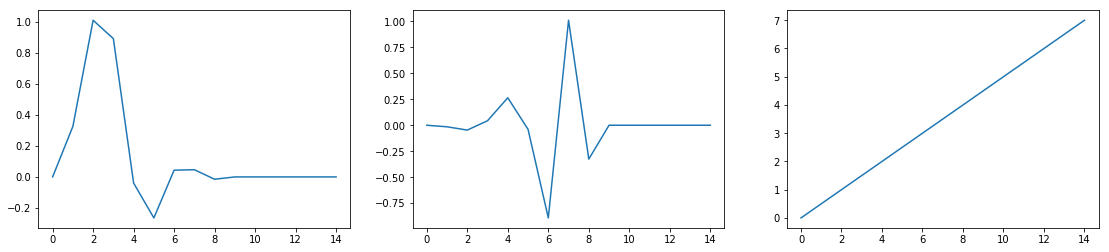

In [442]:
# Code for checking out different wavelets to try:
# # Look at the list of discrete wavelets we have to choose from
# for t in pywt.wavelist(kind='discrete'):
#     print(t)

# Visualize what a particular wavelet function looks like
w = pywt.Wavelet('db4')
# w = pywt.Wavelet('rbio6.8')
# w = pywt.Wavelet('bior3.9')
t = w.wavefun(level=1)
plt.figure(figsize=(19,4))
plt.subplot(1,3,1)
plt.plot(t[0])
plt.subplot(1,3,2)
plt.plot(t[1])
plt.subplot(1,3,3)
plt.plot(t[2])
plt.show()

## Build the Wavelet feature matrix

In [443]:
# Extract features using wavelets on both the raw data and the delta data
raw_wavelet_mat = build_wavelet_feature_matrix(raw_data, 'haar')
delta_wavelet_mat = build_wavelet_feature_matrix(delta_data, 'haar')

# haar basis worked pretty well with agglo clustering
# db38 gives an insanely weird looking PCA plot and performs like crap. Also only gets to level 1
# db3 is okay, reaches level 5
# bior1.1 is also okay, gets level 7 transform
# coif 1 is pretty meh, gets level 5
# sym2 is meh, gets level 6

Max level wavelet reached:  7
Max level wavelet reached:  7


# Extract Features Directly from Signal

I also wanted to try just extracting some features directly from the `raw` and `delta` data, and see how clustering based off of those vectors performed.

In [446]:
def build_direct_feature_matrix(data):
    num_pts = data.shape[1]
    num_feats = 29
    
    feature_mat = np.zeros((num_feats, num_pts))
    
    for i in range(num_pts):
        feature_mat[:,i] = get_features(data[:,i])
        
    return feature_mat

In [447]:
raw_feat_mat = build_direct_feature_matrix(raw_data)
delta_feat_mat = build_direct_feature_matrix(delta_data)

Now we are up to 7 different representations of the data. Each matrix has columns corresponding to our data points, and they each have the same number of columns. However, some have different numbers of rows since for some, the data is still the same length as the original data, just processed, while for other we have extracted features and have a different number of points than the original data.

1. `raw_data` matrix contains the original generation data.
2. `delta_mat` contains the original data that then had the ClearSky forecast subtracted out of it.
3. `freq_data` is such that each column is the FFT of each column of `delta_data`.
4. `raw_wavelet_mat` contains features extracted from the discrete wavelet transform applied to `raw_data`.
5. `delta_wavelet_mat` contains features extracted from the discrete wavelet transform applied to `delta_data`.
6. `raw_feat_mat` contains features extracted directly from each column of `raw_data`.
7. `delta_feat_mat` contains features extracted directly from each column of `delta_data`.

# PCA

Here is a function that performs PCA on the data to let us visualize it a bit. We'll apply it to each data matrix we have.

In [453]:
def do_pca(n_comp, data, data_name='', plot=True):
    '''
    Plot the principal components, their explained variance, and a scatter of the data projected
    onto the top 2 components.
    
    data is shape (n_features, n_data_points)
    '''
    pca = PCA(n_components=n_comp)
    if np.iscomplex(data).any():
        pca.fit(np.abs(data.T))
    else:
        pca.fit(data.T)
    
    if plot:
        plt.figure(figsize=(19,4))
        for i in range(n_comp):
            plt.subplot(n_comp, 1, i+1)
            plt.plot(pca.components_[i, :])

        plt.suptitle('Principal Components of ' + data_name, fontsize=19)
        plt.show()

        plt.figure(figsize=(18, 4))
        plt.subplot(1,2,1)
        plt.plot(pca.explained_variance_)
        plt.xticks(range(n_comp))
        plt.title('Explained Variance')

        plt.subplot(1,2,2)
        if np.iscomplex(data).any():
            proj_data = pca.components_[:2, :] @ np.abs(data)
        else:
            proj_data = pca.components_[:2, :] @ data
        plt.scatter(proj_data[0,:], proj_data[1,:])
        plt.title('PCA Scatter')
        plt.show()
        
        print() # To add space at end
    
    return pca, proj_data

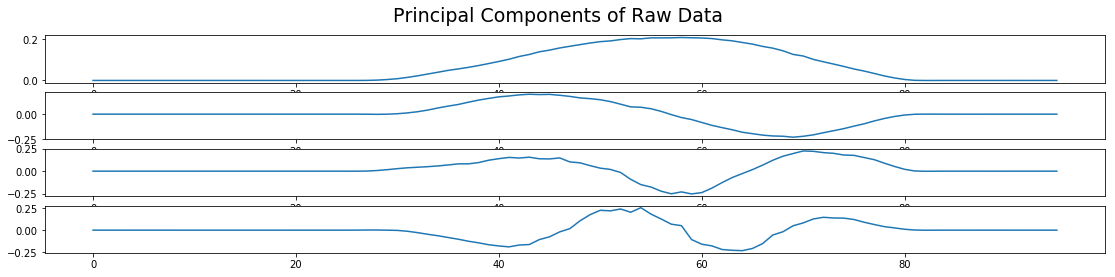

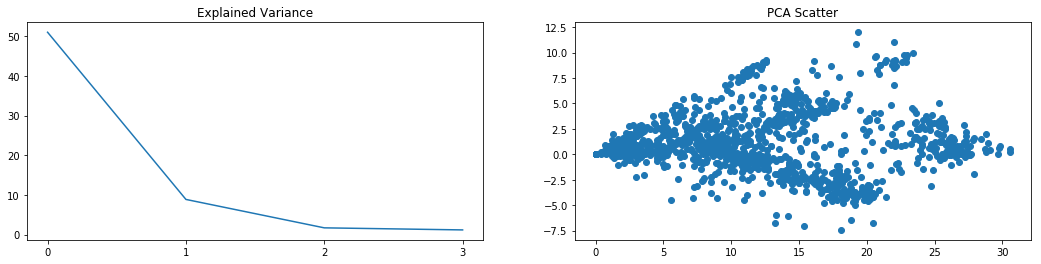

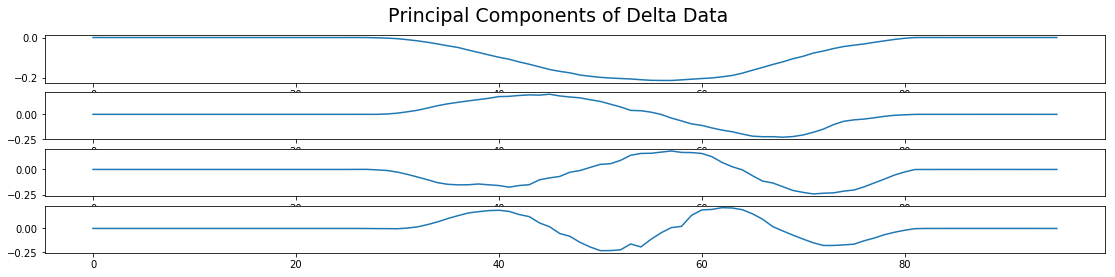

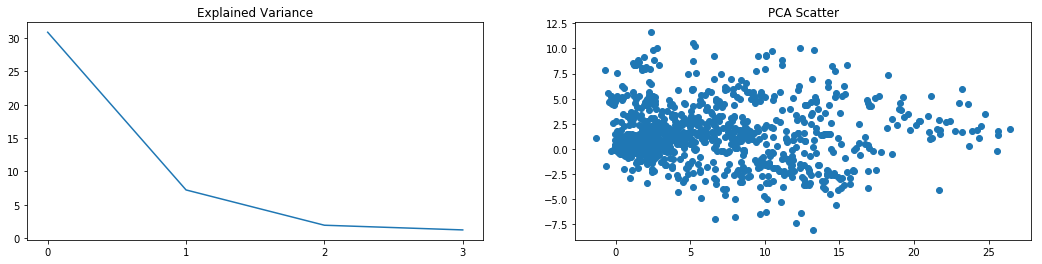

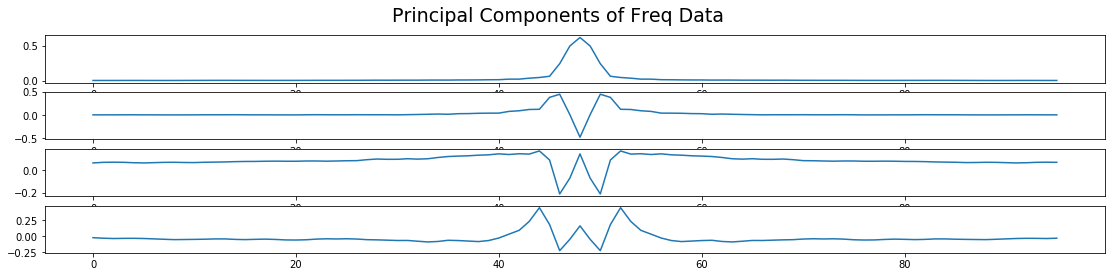

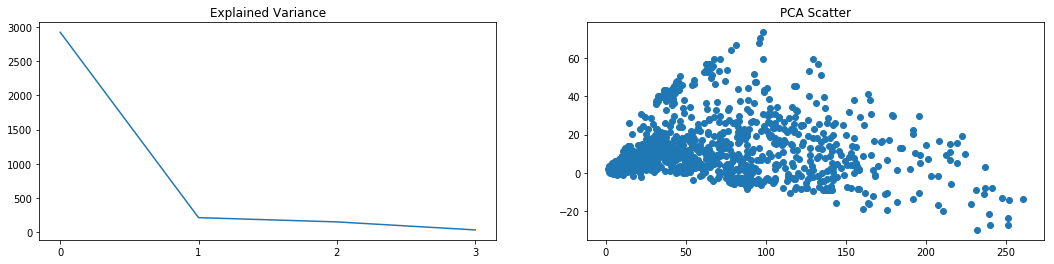

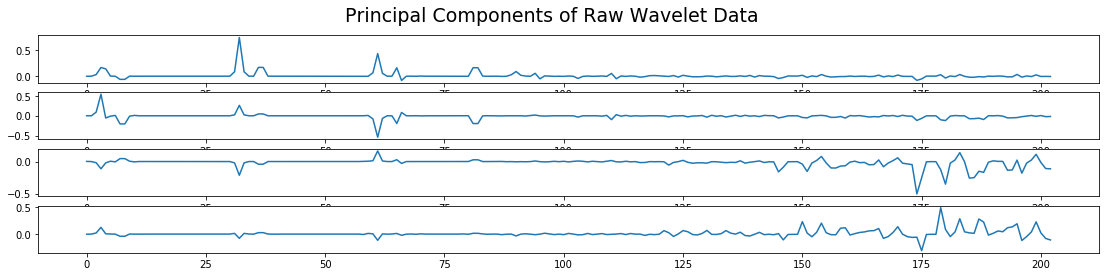

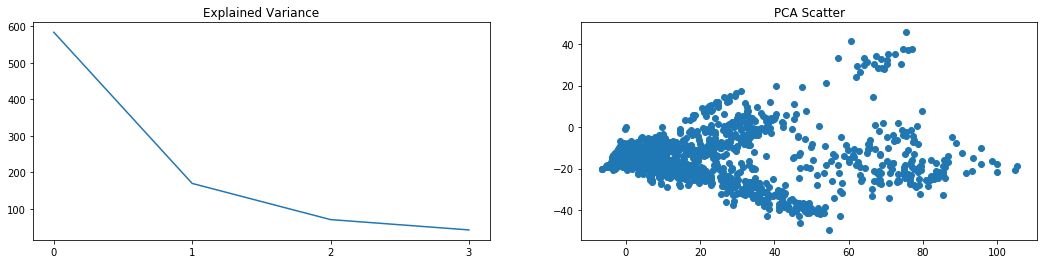

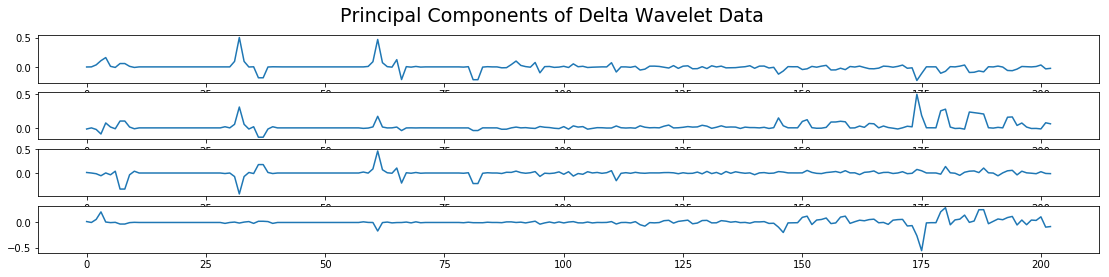

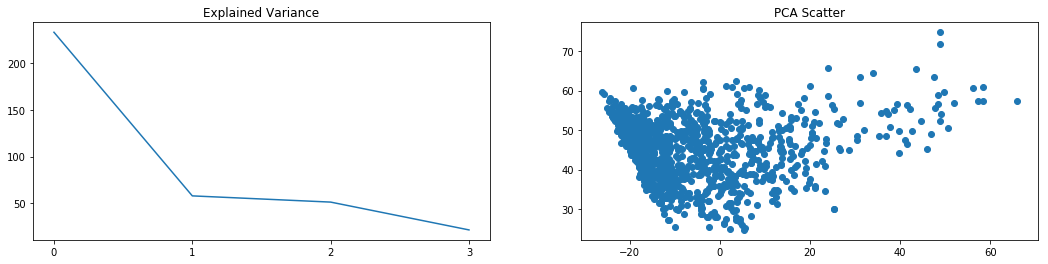

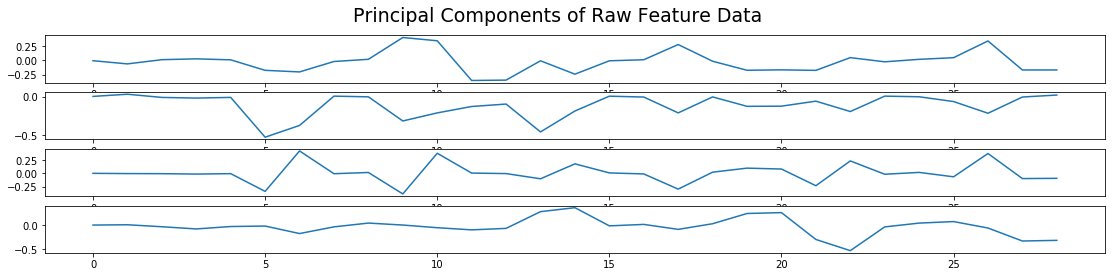

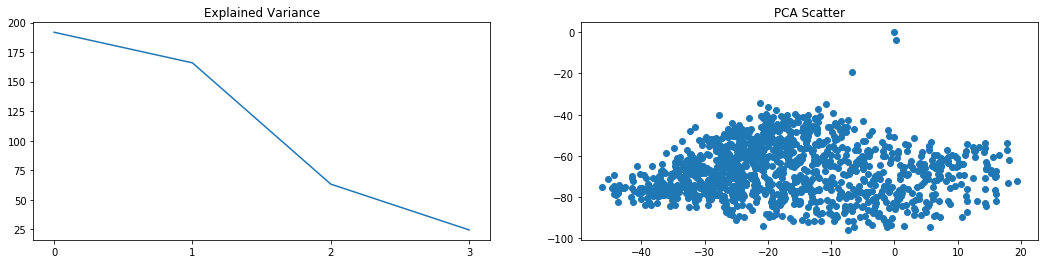

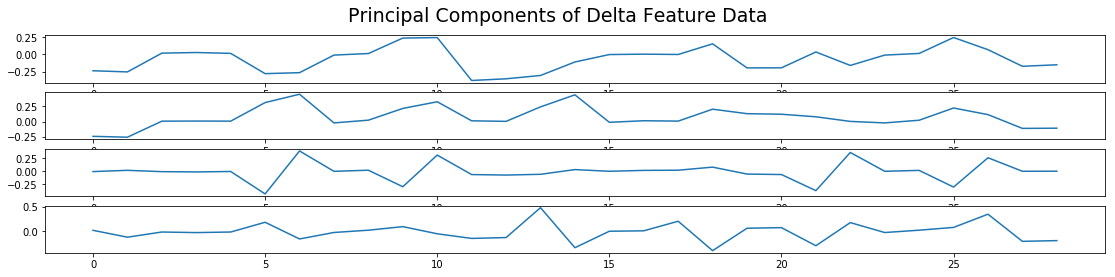

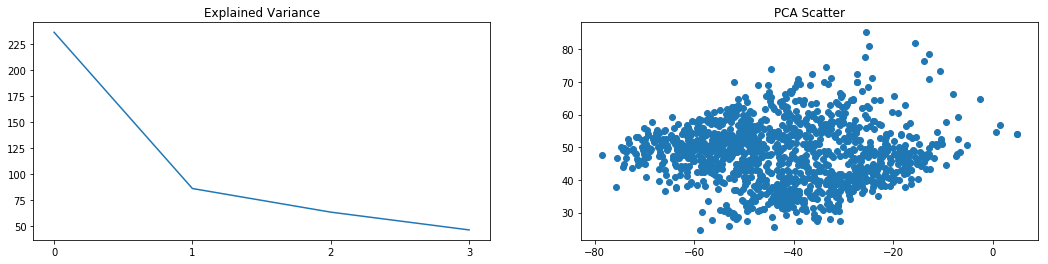

In [454]:
num_pca_comp = 4

raw_pca, raw_proj = do_pca(num_pca_comp, raw_data, 'Raw Data')
delta_pca, delta_proj = do_pca(num_pca_comp, delta_data, 'Delta Data')
freq_pca, freq_proj = do_pca(num_pca_comp, freq_data, 'Freq Data')
raw_wav_pca, raw_wav_proj = do_pca(num_pca_comp, raw_wavelet_mat, 'Raw Wavelet Data')
delta_wav_pca, delta_wav_proj = do_pca(num_pca_comp, delta_wavelet_mat, 'Delta Wavelet Data')
raw_feat_pca, raw_feat_proj = do_pca(num_pca_comp, raw_feat_mat, 'Raw Feature Data')
delta_feat_pca, delta_feat_proj = do_pca(num_pca_comp, delta_feat_mat, 'Delta Feature Data')


# Clustering

Now, create a pipeline of clustering for the columns and apply it to each data matrix.

In [459]:
CENTROID_FIGSIZE = (19,4)
SAMPLE_FIGSIZE = (19,5)

## K-Means

So it actually looks like Kmeans does a pretty good job of finding samples that have similar shape to each other, both when using the time domain as well as frequency domain data. However, it also seems to have a very strong tendency to cluster together days that have similar heights, not just shapes, meaning many clear days still end up in different clusters if they have different heights, and also that clear days and overcast days still end up in the same cluster when they have similar height.

Fortunately, this tendency seems less prevalant when the clustering is done on the magnitude of the tranformed data, although it's still not perfect.

Also, in both cases, it seems like having more clusters let's the algorithm really identify some consistent clusters pretty well. As in, it'll find a nice cluster of many days that look very similar to each other, while other clusters will be more of the 'leftovers' cluster, which are more mixed bags.

In [473]:
from sklearn.cluster import KMeans

def do_kmeans(data, proj_data, n_clust_range=range(4,9), plot=True, plot_raw_data=False):
    '''
    Run kmeans on the data, using each value in n_clust_range as the number of clusters to try.
    Then, plot the centroids, the PCA scatter with labels according to the clustering, and random
    samples of the data from each cluster
    
    data is of shape (n_features, n_data_points), so cols are days and rows are time intervals
    
    For plotting, if plot_raw_data is true, the plots of samples from each cluster will be plots
    of the raw data (data without clearsky subtracted out)
    If plot_raw_data is false, then the samples plotted from each cluster will have the clearsky
    estimate subtracted out (i.e. it'll plot the delta_data instead)
    '''
    if np.iscomplex(data).any():
        data = np.abs(data)

    for n_clust in n_clust_range:
        kmeans = KMeans(n_clusters=n_clust).fit(data.T)

        # Plot the centroids
        plt.figure(figsize=CENTROID_FIGSIZE)
        for i in range(n_clust):
            plt.subplot(n_clust, 1, i+1)
            plt.plot(kmeans.cluster_centers_[i,:])

        plt.suptitle('KMeans Cluster Centroids K = ' + str(n_clust))
        plt.show()

        # PCA scatter with colored labels
        plt.figure()
        plt.scatter(proj_data[0,:], proj_data[1,:], c=kmeans.labels_)
        plt.title('KMeans PCA Scatter with Labels K = ' + str(n_clust))
        plt.show()

        # Plot some random samples from each cluster
        plt.figure(figsize=SAMPLE_FIGSIZE)
        for i in range(n_clust):
            clust = np.argwhere(kmeans.labels_ == i).squeeze()
            num_plot = np.minimum(10, len(clust))
            samps = np.random.choice(clust, size=num_plot, replace=False)
            if plot_raw_data:
                concat_samps = np.array([raw_data[:, s] for s in samps])
            else:
                concat_samps = np.array([delta_data[:, s] for s in samps])
            plt.subplot(n_clust, 1, i+1)
            plt.plot(concat_samps.ravel())
        plt.suptitle('KMeans Cluster Samples K = ' + str(n_clust), fontsize=14)
        plt.show()

## Agglomerative Clustering

Off the bat, agglomerative clustering with euclidean affinity and ward linkage seems to work very well for clustering data into similarly shaped days. It seems to have less of the problem that kmeans had, which was that it would cluster things together that had similar low-frequency shape (i.e. height) resulting in similarly smooth days being in separate clusters, and days with smooth and overcast parts being in the same cluster just because they were the same height. AgC seems to avoid that rather well.

Now to experiment with changing affinity and linkage to see if that does anything.

Trying L1 for affinity and average for linkage, it seems like it also works quite well.

Another idea is to try high-pass filtering the data first, to remove the algorithms' ability to rely too strongly on the low-frequency content for clustering.

In [472]:
from sklearn.cluster import AgglomerativeClustering

def do_agglo_clustering(data, proj_data, n_clust_range=range(4,9), plot=True, plot_raw_data=False,
                       affinity='euclidean', linkage='ward'):
    '''
    Run agglomerative clustering on the data, using each value in n_clust_range as the number 
    of clusters to try. Then, plot the centroids, the PCA scatter with labels according to 
    the clustering, and random samples of the data from each cluster
    
    data is of shape (n_features, n_data_points), so cols are days and rows are time intervals
    
    For plotting, if plot_raw_data is true, the plots of samples from each cluster will be plots
    of the raw data (data without clearsky subtracted out)
    If plot_raw_data is false, then the samples plotted from each cluster will have the clearsky
    estimate subtracted out (i.e. it'll plot the delta_data instead)
    '''
    if np.iscomplex(data).any():
        data = np.abs(data)
        
    for n_clust in n_clust_range:
        agc = AgglomerativeClustering(n_clusters=n_clust, affinity=affinity, linkage=linkage).fit(data.T)

        # PCA scatter with colored labels
        plt.figure()
        plt.scatter(proj_data[0,:], proj_data[1,:], c=agc.labels_)
        plt.title('Agglomerative PCA Scatter with Labels K = ' + str(n_clust))
        plt.show()

        # Plot some random samples from each cluster
        plt.figure(figsize=SAMPLE_FIGSIZE)
        for i in range(n_clust):
            clust = np.argwhere(agc.labels_ == i).squeeze()
            if clust.size <= 1:
                print('Found an empty one')
                continue
            num_plot = np.minimum(10, len(clust))
            samps = np.random.choice(clust, size=num_plot, replace=False)
            if plot_raw_data:
                concat_samps = np.array([raw_data[:, s] for s in samps])
            else:
                concat_samps = np.array([delta_data[:, s] for s in samps])
            plt.subplot(n_clust, 1, i+1)
            plt.plot(concat_samps.ravel())
        plt.suptitle('Agglomerative Cluster Samples K = ' + str(n_clust), fontsize=14)
        plt.show()

## Gaussian Mixture

Gaussian Mixture sucks for the time domain data, but it seems to do alright on the frequncy data. The thing is, the means all look quite similar for the frequency data, and they just get steadily fatter tails is kinda all that's happening (except in the case where it has the dimple in the middle). Again, thinking if I high-pass filtered the data first, that might mitigate that problem.

In [471]:
from sklearn.mixture import GaussianMixture

def do_gaussian_mixture(data, proj_data, n_clust_range=range(4,9), plot=True, plot_raw_data=False):
    '''
    Cluster the data using gaussian mixture model, trying it with number of components equal to each
    value in n_comp_range.
    Then, plot the means from the learned distributions, the PCA scatter with labels according to 
    the clustering, and random samples of the data from each cluster
    
    data is of shape (n_features, n_data_points), so cols are days and rows are time intervals
    
    For plotting, if plot_raw_data is true, the plots of samples from each cluster will be plots
    of the raw data (data without clearsky subtracted out)
    If plot_raw_data is false, then the samples plotted from each cluster will have the clearsky
    estimate subtracted out (i.e. it'll plot the delta_data instead)
    '''
    if np.iscomplex(data).any():
        data = np.abs(data)

    for n_comp in n_clust_range:
        gmm = GaussianMixture(n_components=n_comp).fit(data.T)

        # Plot the means of each component
        plt.figure(figsize=CENTROID_FIGSIZE)
        for i in range(n_comp):
            plt.subplot(n_comp, 1, i+1)
            plt.plot(gmm.means_[i,:])

        plt.suptitle('Gaussian Mixture Distribution Means K = ' + str(n_comp))
        plt.show()

        # PCA scatter with colored labels
        labels = gmm.predict(data.T)
        plt.figure()
        plt.scatter(proj_data[0,:], proj_data[1,:], c=labels)
        plt.title('Gaussian Mixture PCA Scatter with Labels K = ' + str(n_comp))
        plt.show()

        # Plot some random samples from each cluster
        plt.figure(figsize=SAMPLE_FIGSIZE)
        for i in range(n_comp):
            clust = np.argwhere(labels == i).squeeze()
            num_plot = np.minimum(10, len(clust))
            samps = np.random.choice(clust, size=num_plot, replace=False)
            if plot_raw_data:
                concat_samps = np.array([raw_data[:, s] for s in samps])
            else:
                concat_samps = np.array([delta_data[:, s] for s in samps])
            plt.subplot(n_comp, 1, i+1)
            plt.plot(concat_samps.ravel())
        plt.suptitle('Gaussian Mixture Cluster Samples K = ' + str(n_comp), fontsize=14)
        plt.show()


## Clustering the data

In [463]:
# Number of clusters to try clustering into for each alg
# For now, just trying to see if we can even consistently separate days with overcast vs. clear days
num_clust_range = range(2,3)

plot_raw_data=True

In [479]:
def run_cluster_funcs(data, proj_data, n_clust_range=None, plot_raw_data=True):
    do_kmeans(data, proj_data, n_clust_range=n_clust_range, plot_raw_data=plot_raw_data)
    print('\n\n\n\n')
    print('----------------------------------------------------------------------------------------')
    print('\n\n\n\n')
    do_agglo_clustering(data, proj_data, n_clust_range=n_clust_range, plot_raw_data=plot_raw_data, 
                       affinity='l1', linkage='average')
    print('\n\n\n\n')
    print('----------------------------------------------------------------------------------------')
    print('\n\n\n\n')
    do_gaussian_mixture(data, proj_data, n_clust_range=n_clust_range, plot_raw_data=plot_raw_data)

### Raw Data

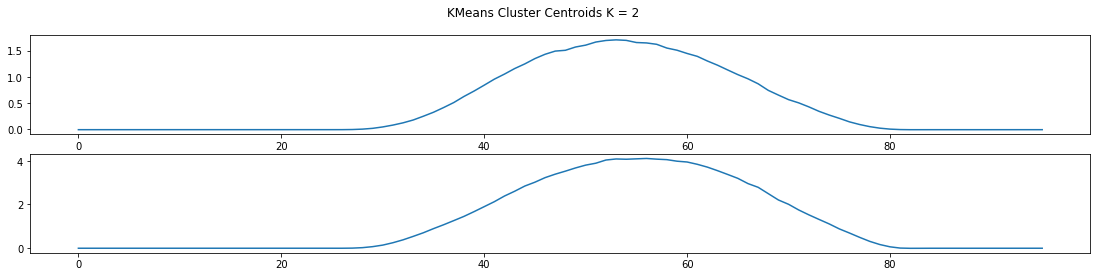

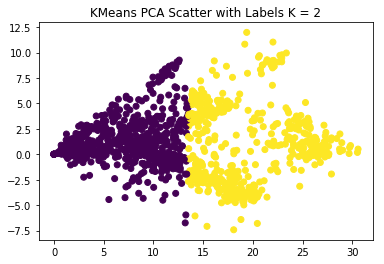

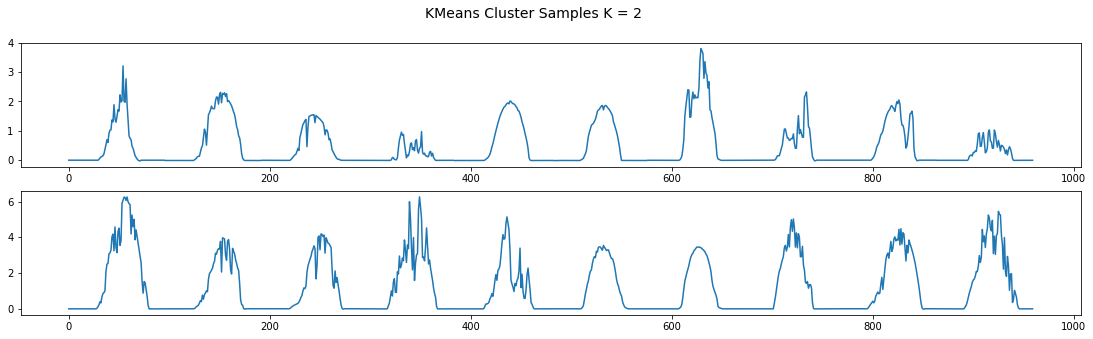






----------------------------------------------------------------------------------------







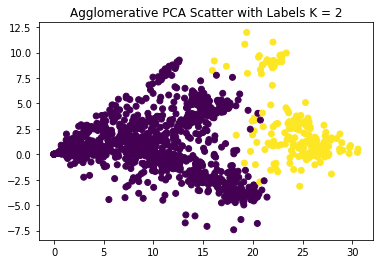

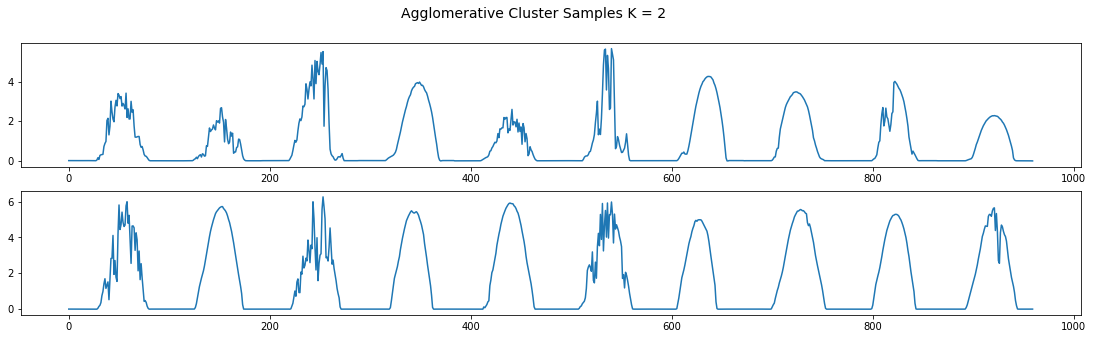






----------------------------------------------------------------------------------------







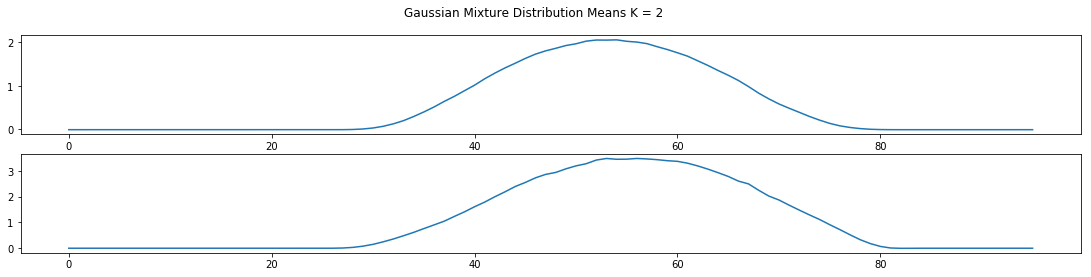

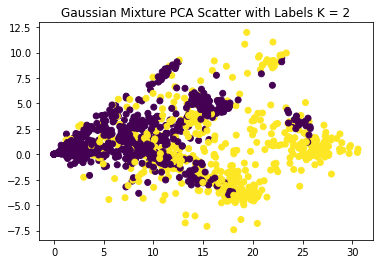

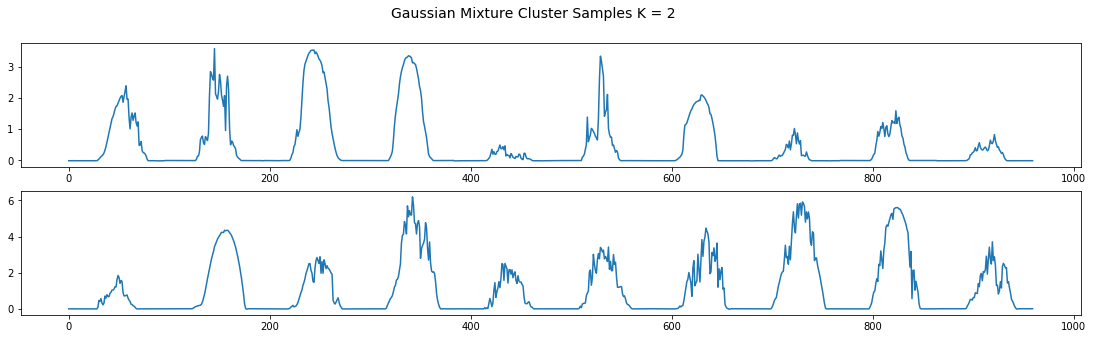

In [480]:
run_cluster_funcs(raw_data, raw_proj, num_clust_range)

### Delta Data

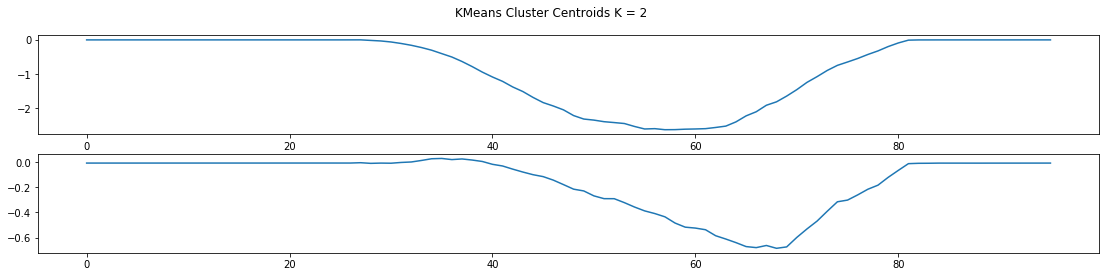

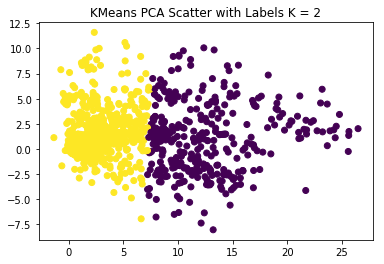

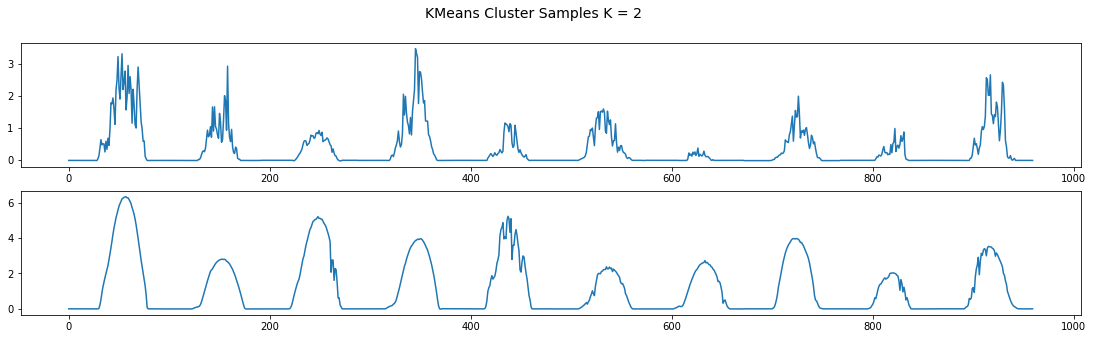






----------------------------------------------------------------------------------------







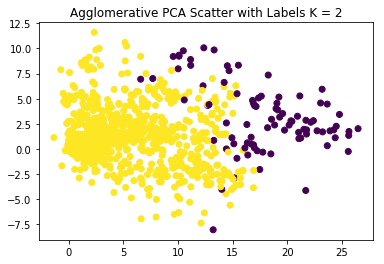

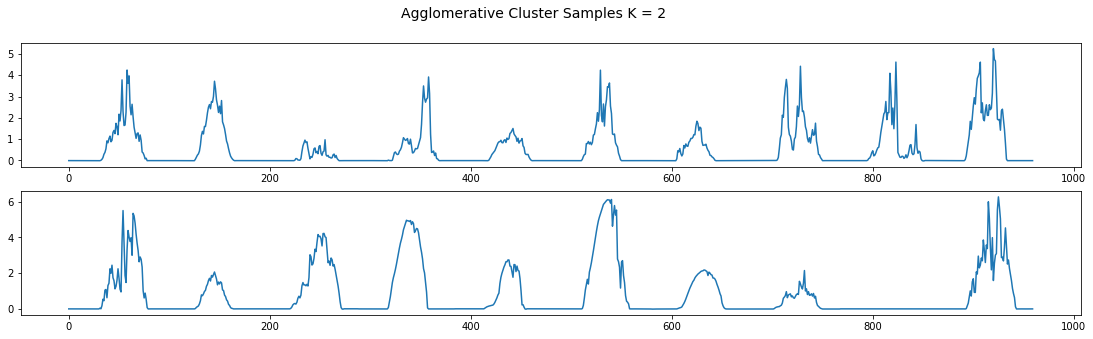






----------------------------------------------------------------------------------------







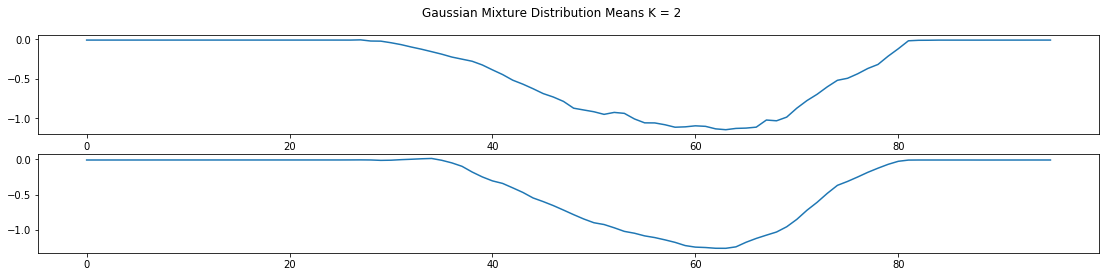

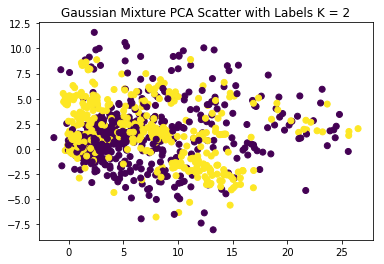

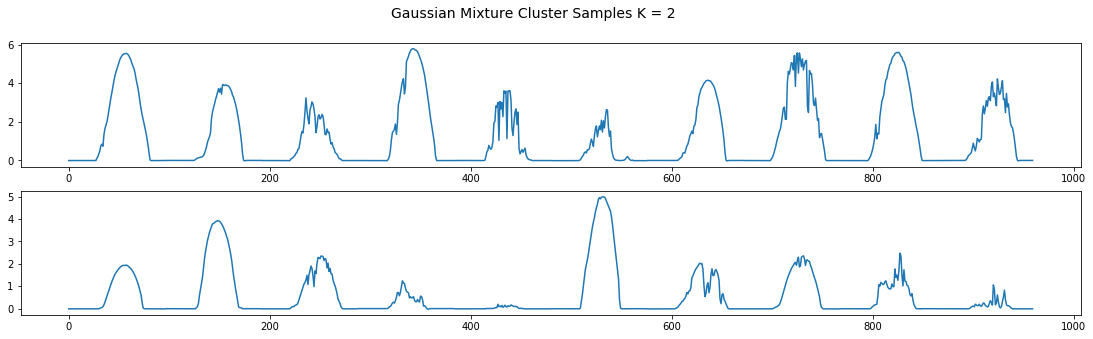

In [487]:
run_cluster_funcs(delta_data, delta_proj, num_clust_range)

### Freq Data

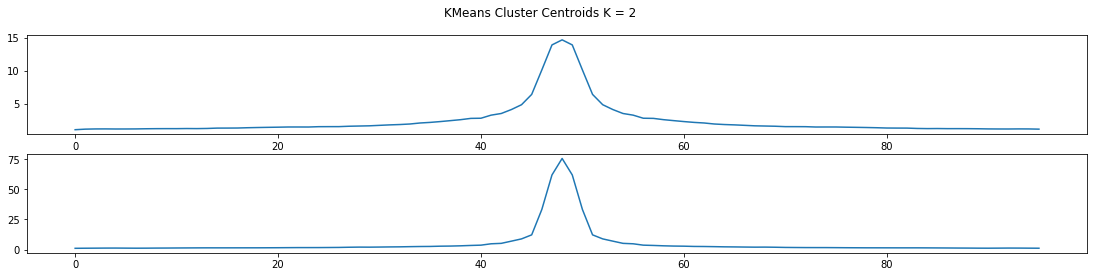

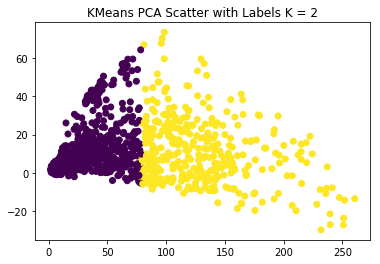

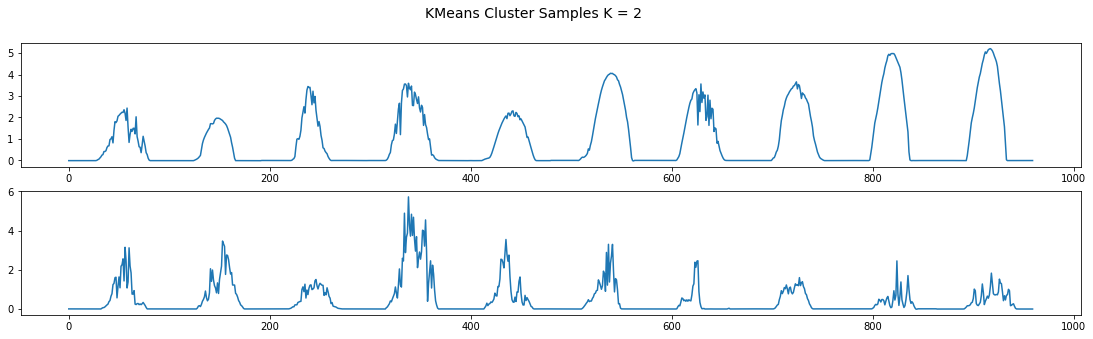






----------------------------------------------------------------------------------------







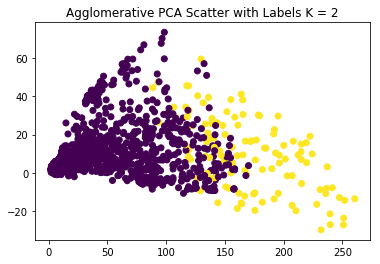

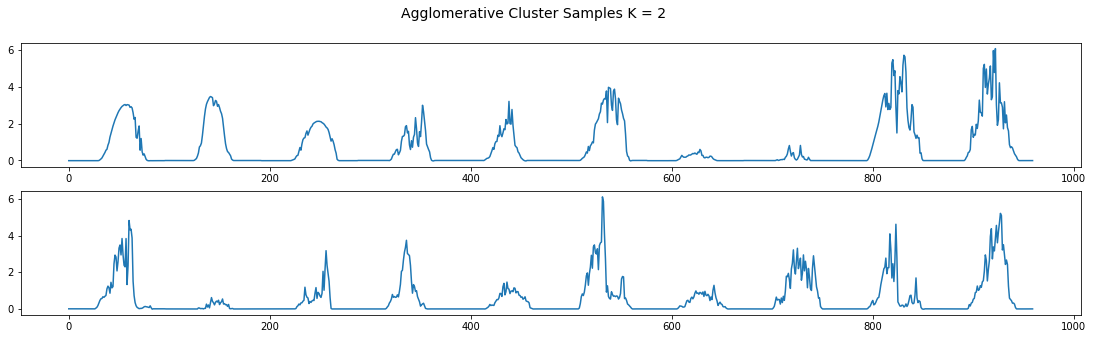






----------------------------------------------------------------------------------------







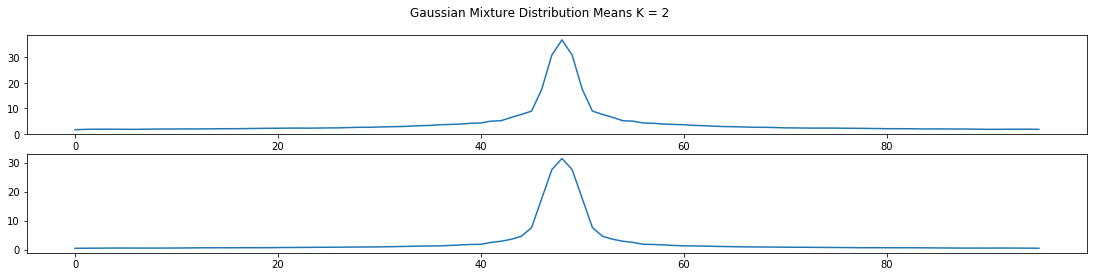

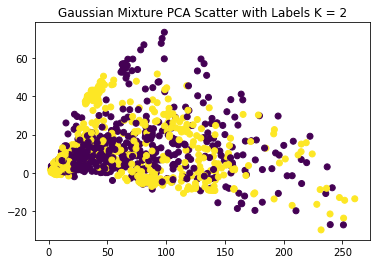

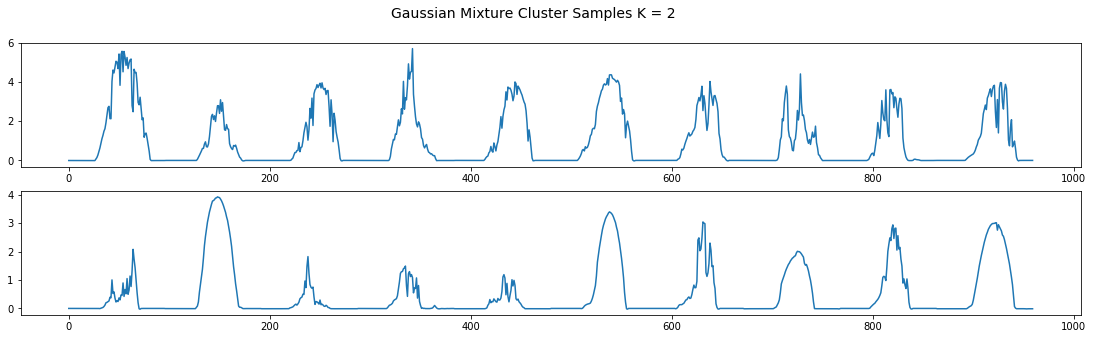

In [488]:
run_cluster_funcs(freq_data, freq_proj, num_clust_range)

### Raw Wavelet Data

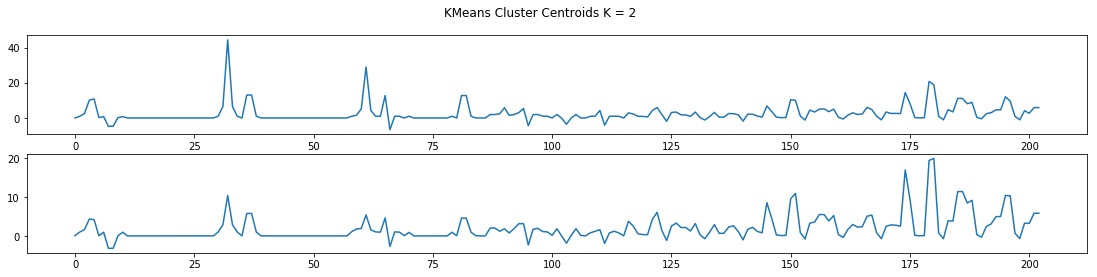

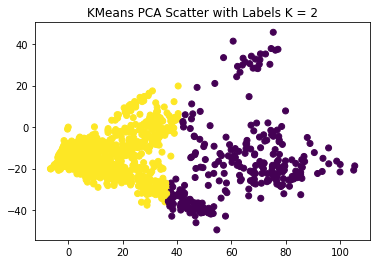

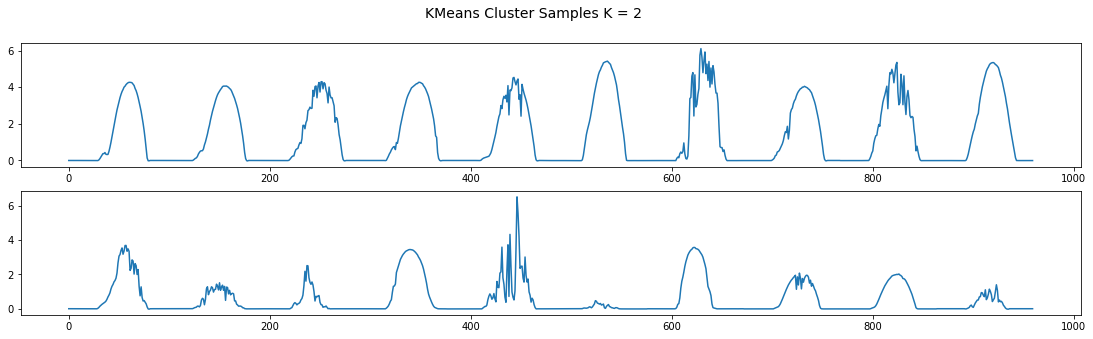






----------------------------------------------------------------------------------------







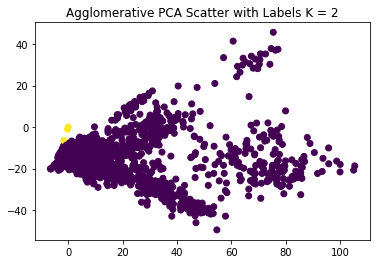

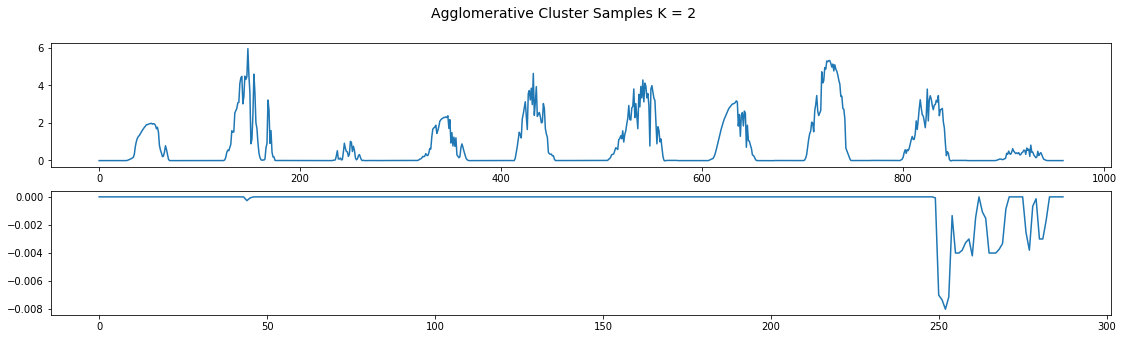






----------------------------------------------------------------------------------------







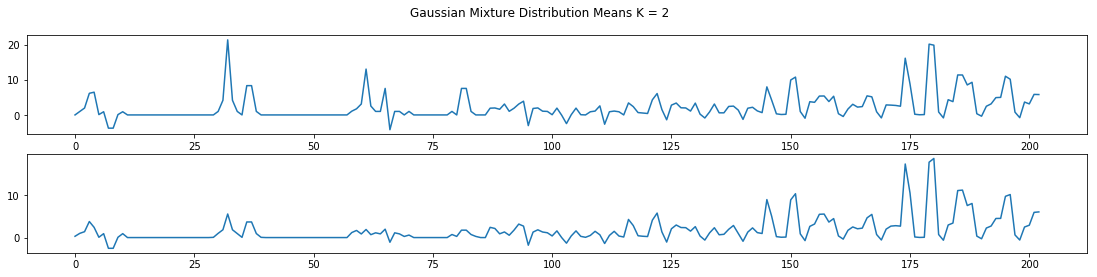

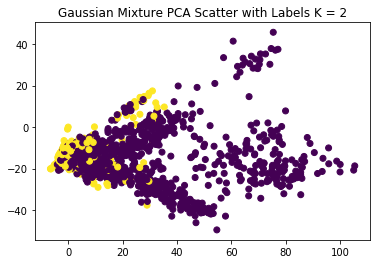

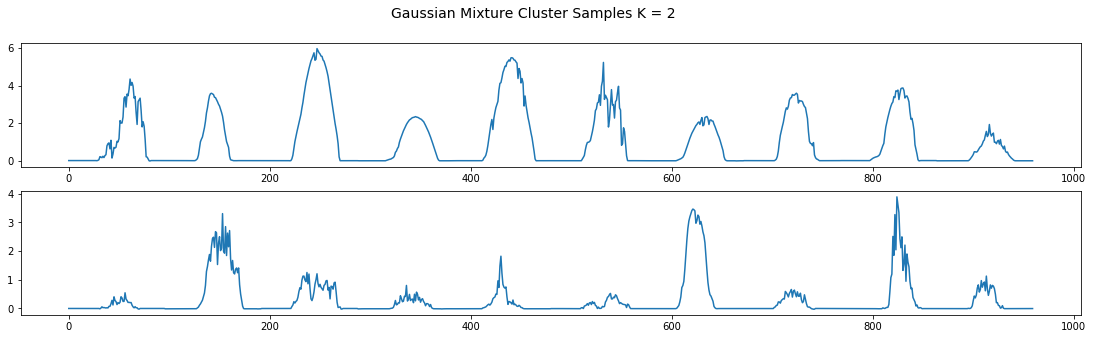

In [482]:
run_cluster_funcs(raw_wavelet_mat, raw_wav_proj, num_clust_range)

### Delta Wavelet Data

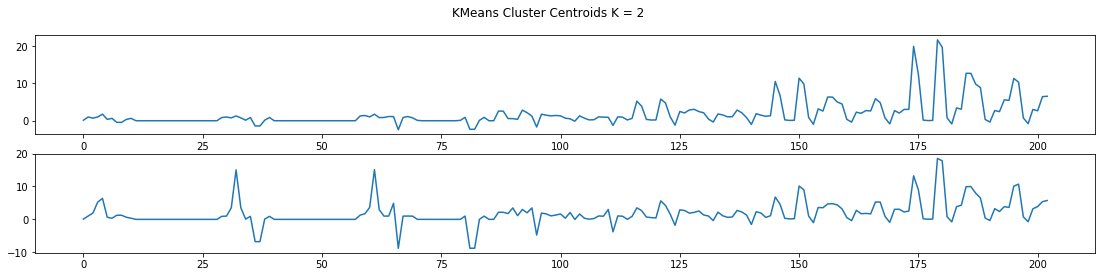

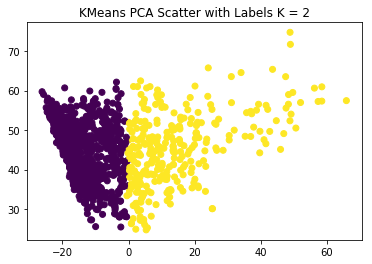

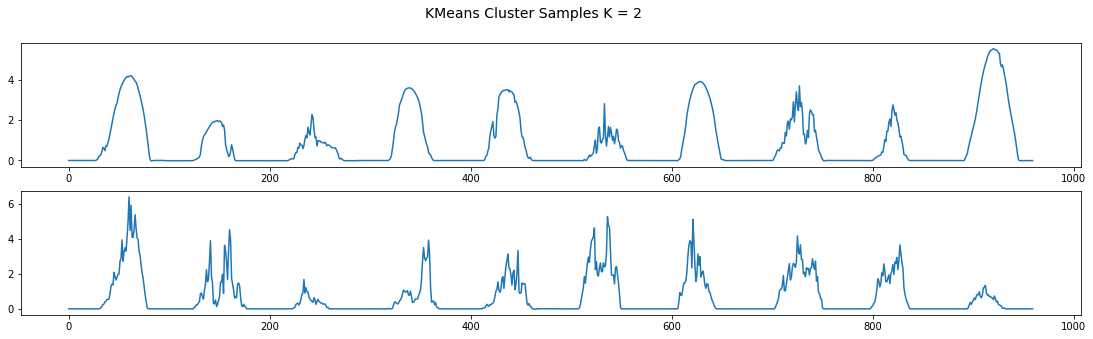






----------------------------------------------------------------------------------------







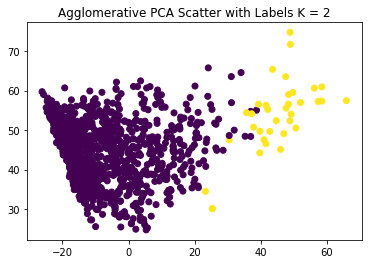

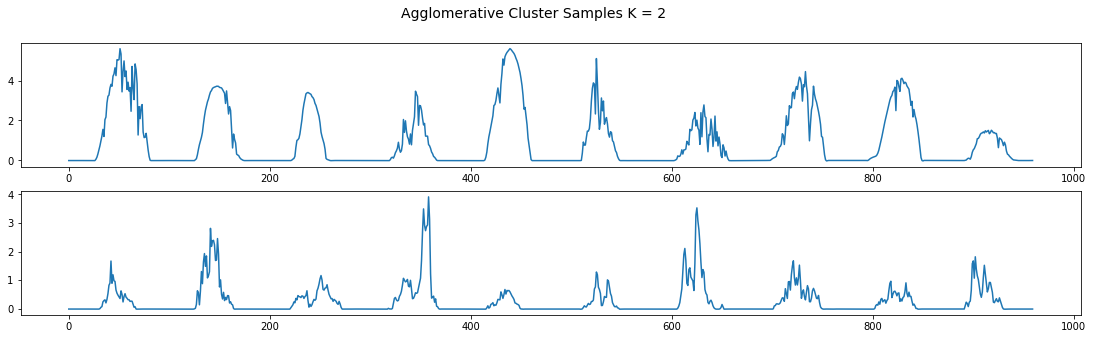






----------------------------------------------------------------------------------------







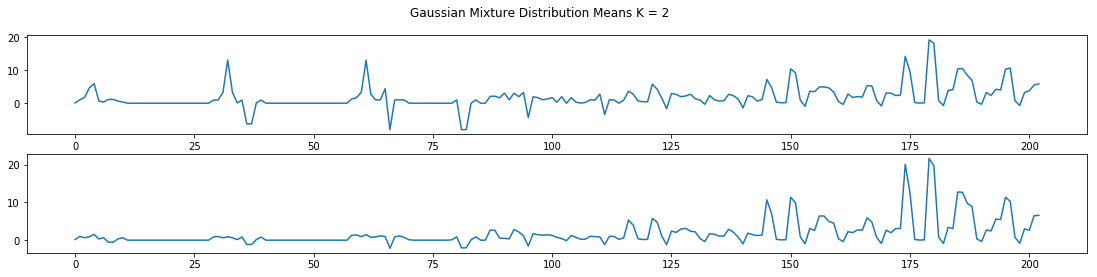

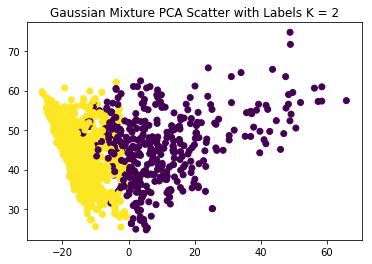

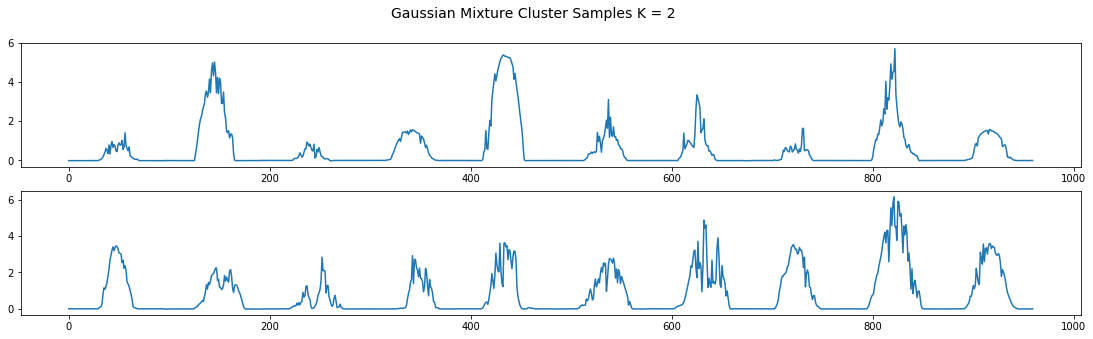

In [483]:
run_cluster_funcs(delta_wavelet_mat, delta_wav_proj, num_clust_range)

### Raw Feature Data

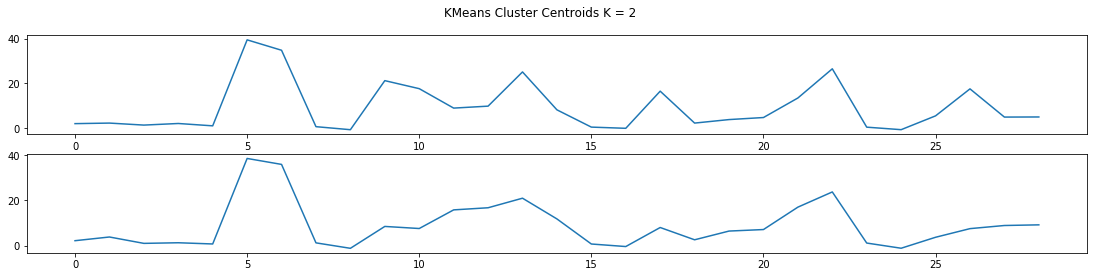

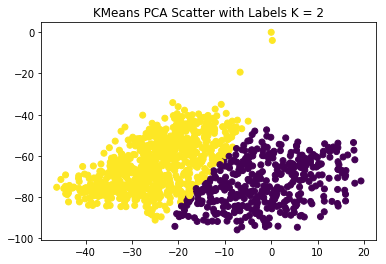

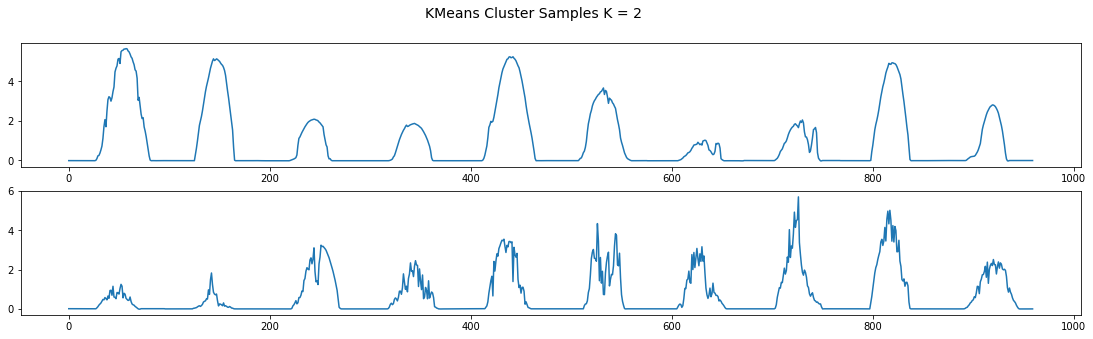






----------------------------------------------------------------------------------------







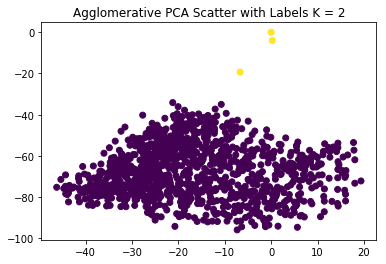

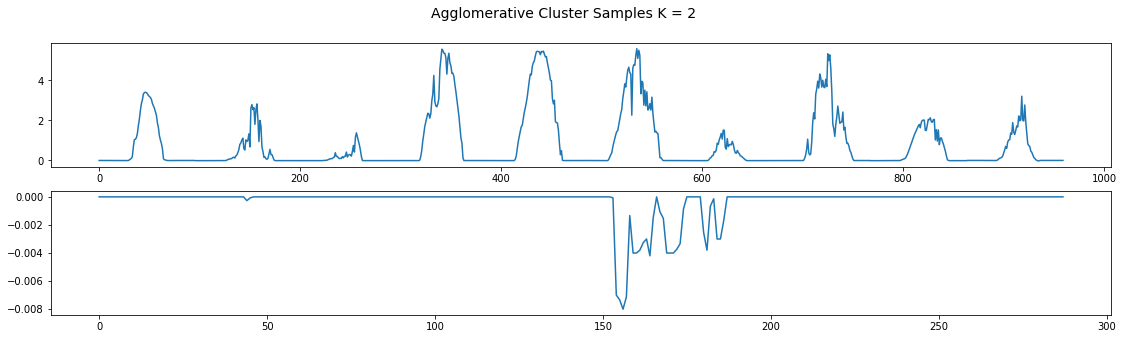






----------------------------------------------------------------------------------------







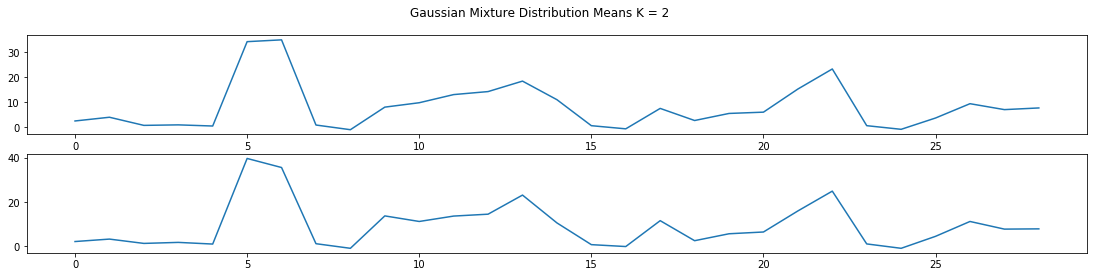

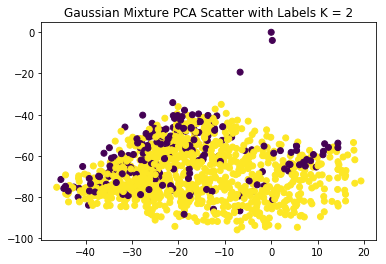

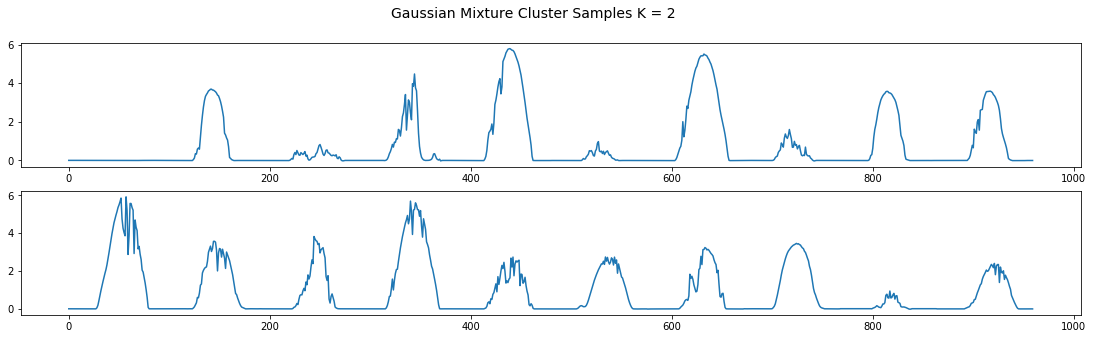

In [484]:
run_cluster_funcs(raw_feat_mat, raw_feat_proj, num_clust_range)

### Delta Feature Data

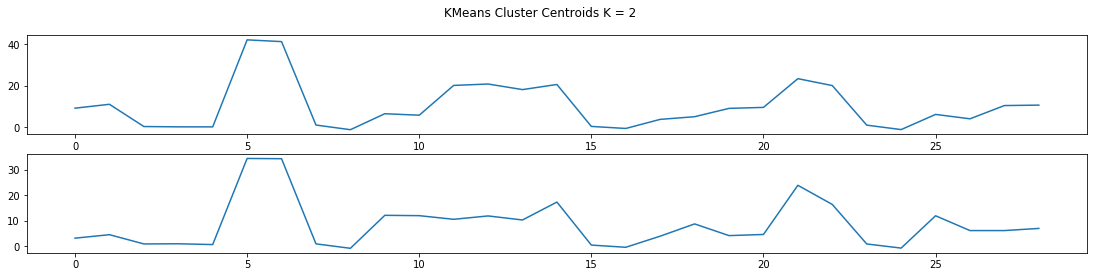

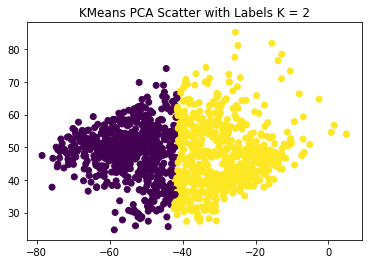

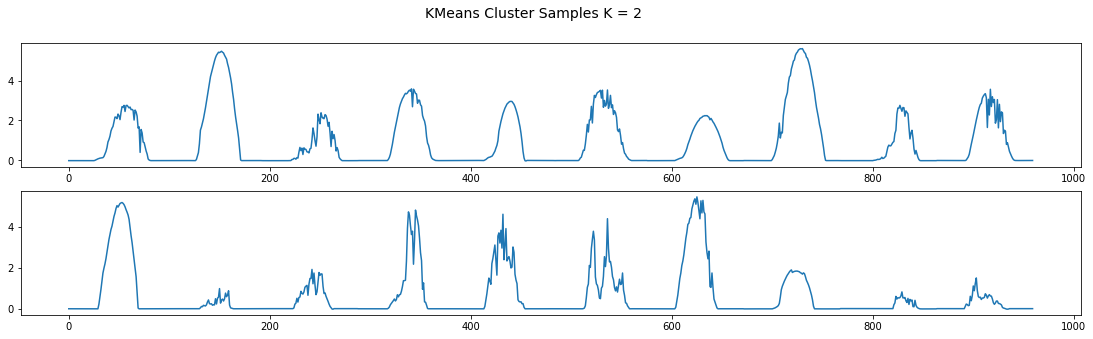






----------------------------------------------------------------------------------------







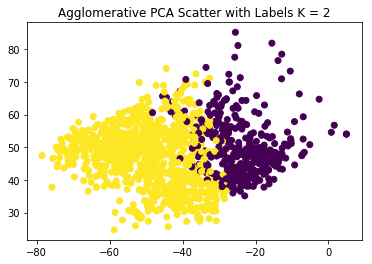

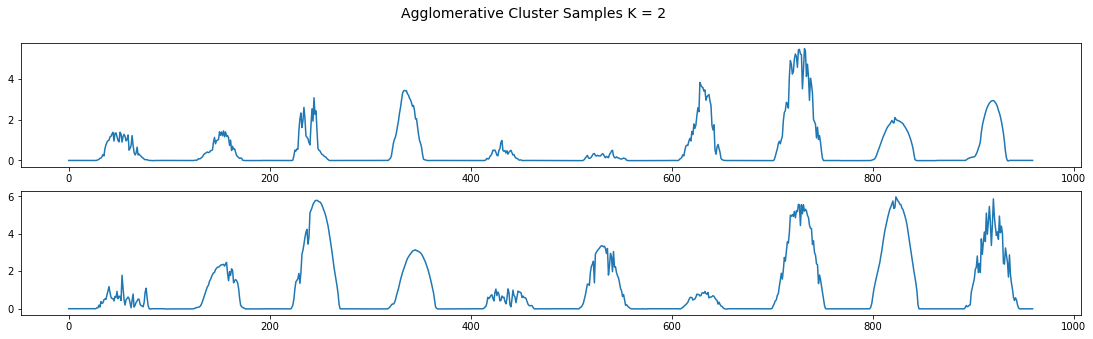






----------------------------------------------------------------------------------------







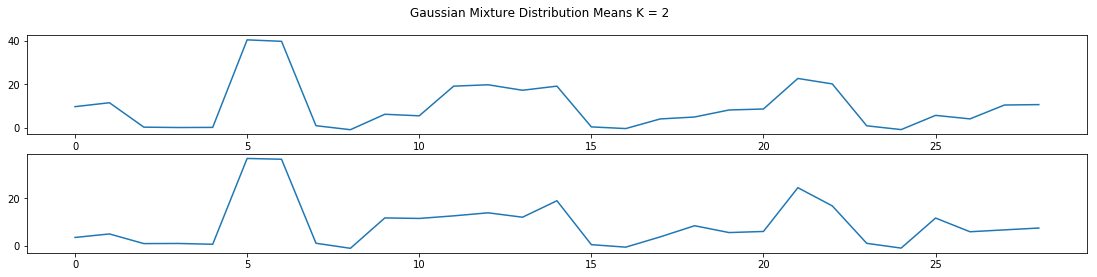

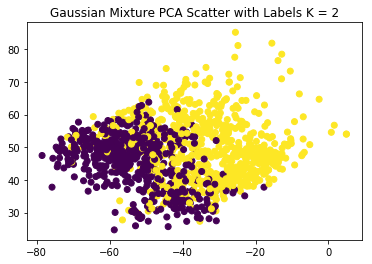

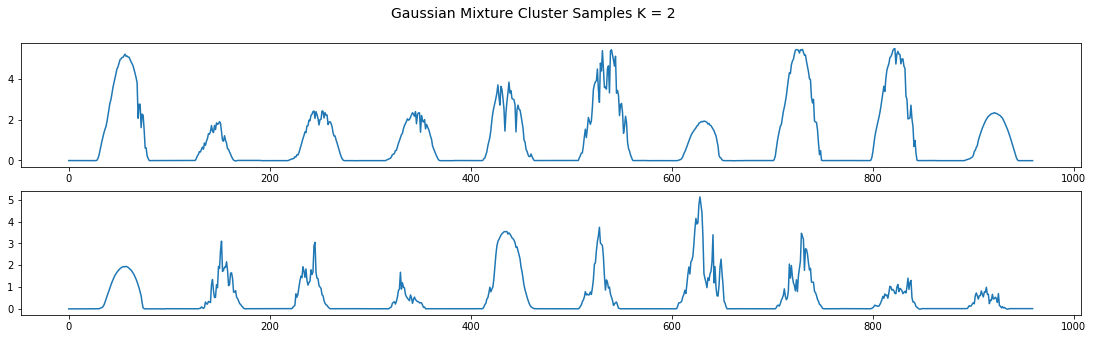

In [486]:
run_cluster_funcs(delta_feat_mat, delta_feat_proj, num_clust_range)

#  I think there's missing data in solar_home 3

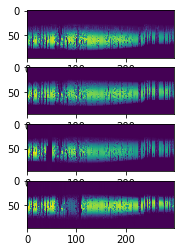

In [192]:
plt.subplot(4,1,1)
plt.imshow(daily_mat[:, :num_days])
plt.subplot(4,1,2)
plt.imshow(daily_mat[:, num_days:num_days*2])
plt.subplot(4,1,3)
plt.imshow(daily_mat[:, num_days*2:num_days*3])
plt.subplot(4,1,4)
plt.imshow(daily_mat[:, num_days*3:])

plt.show()